In [1]:
import os
import sys
import gc
import pickle
import warnings
import pandas as pd
import numpy as np
import seaborn as sns
from typing import *
from tqdm.notebook import tqdm
from pathlib import Path
from matplotlib import pyplot as plt

pd.set_option('max_columns', 50)
warnings.simplefilter('ignore')

In [2]:
base_dir = Path().resolve()
sys.path.append(str(base_dir / '../'))

from utils.preprocess import *
from utils.model import *
from utils.train import *

fail to import apex_C: apex was not installed or installed without --cpp_ext.
fail to import amp_C: apex was not installed or installed without --cpp_ext.


In [3]:
def seed_everything(seed: int, device: str):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    with torch.cuda.device(device):
        torch.cuda.empty_cache()

In [6]:
from dataclasses import dataclass, field, asdict
import yaml


@dataclass
class Config:
    # General
    debug: bool = False
    outdir: str = "results01"
    device: str = "cuda:1"

    # Data config
    imgdir_name: str = "../../data/ChestXRay14"
    seed: int = 111
    n_splits: int = 10
    label_smoothing: float = 1e-2
    
    # Model config
    model_name: str = "resnet18"
    model_mode: str = "normal"  # normal, cnn_fixed supported
        
    # Training config
    epoch: int = 20
    lr: float = 1e-4
    batchsize: int = 8
    valid_batchsize: int = 16
    patience: int = 3
    num_workers: int = 4
    snapshot_freq: int = 5
    lr_start: int = 1e-1
    lr_end: int = 1e-3
#     scheduler_type: str = ""
#     scheduler_kwargs: Dict[str, Any] = field(default_factory=lambda: {})
    aug_kwargs: Dict[str, Dict[str, Any]] = field(default_factory=lambda: {})
    mixup_prob: float = 0.
    oversample: bool = False
    downsample: bool = False

    def update(self, param_dict: Dict) -> "Config":
        # Overwrite by `param_dict`
        for key, value in param_dict.items():
            if not hasattr(self, key):
                raise ValueError(f"[ERROR] Unexpected key for flag = {key}")
            setattr(self, key, value)
        return self
    
    def to_yaml(self, filepath: str, width: int = 120):
        with open(filepath, 'w') as f:
            yaml.dump(asdict(self), f, width=width)

In [7]:
config_dict = {
    "debug": False,
    # Data config
    "n_splits": 5,
    "label_smoothing": 0,
    # Model
    "model_name": "xception",
    # Training
    "num_workers": 4,
    "epoch": 25,
    "batchsize": 8,
    "lr": 1e-3,
    "patience": 5,
#     "scheduler_type": "CosineAnnealingWarmRestarts",
#     "scheduler_kwargs": {"T_0": 7032, 'verbose': True},  # 15000 * 15 epoch // (batchsize=8)
    "lr_start": 1e-3,
    "lr_end": 1e-5,
    "aug_kwargs": {
        "HorizontalFlip": {"p": 0.5},
        "ShiftScaleRotate": {"scale_limit": 0.15, "rotate_limit": 10, "p": 0.5},
        "RandomBrightnessContrast": {"p": 0.5},
        "CoarseDropout": {"max_holes": 8, "max_height": 25, "max_width": 25, "p": 0.5},
        "Blur": {"blur_limit": [3, 7], "p": 0.5},
        "Downscale": {"scale_min": 0.25, "scale_max": 0.9, "p": 0.3},
        "RandomGamma": {"gamma_limit": [80, 120], "p": 0.6},
    },
    "mixup_prob": 0,
    "oversample": False,
    "downsample": True
}

config = Config().update(config_dict)

In [8]:
skf = StratifiedKFoldWrapper(
    datadir=base_dir / config.imgdir_name,
    n_splits=config.n_splits,
    shuffle=True,
    seed=config.seed,
    label_smoothing=config.label_smoothing,
    mixup_prob=config.mixup_prob,
    aug_kwargs=config.aug_kwargs,
    debug=config.debug,
    oversample=config.oversample,
    downsample=config.downsample,
)

In [11]:
config.to_yaml(str(base_dir / config.outdir / 'config.yaml'))
config

Config(debug=False, outdir='results01', device='cuda:1', imgdir_name='../../data/ChestXRay14', seed=111, n_splits=5, label_smoothing=0, model_name='xception', model_mode='normal', epoch=25, lr=0.001, batchsize=8, valid_batchsize=16, patience=5, num_workers=4, snapshot_freq=5, lr_start=0.001, lr_end=1e-05, aug_kwargs={'HorizontalFlip': {'p': 0.5}, 'ShiftScaleRotate': {'scale_limit': 0.15, 'rotate_limit': 10, 'p': 0.5}, 'RandomBrightnessContrast': {'p': 0.5}, 'CoarseDropout': {'max_holes': 8, 'max_height': 25, 'max_width': 25, 'p': 0.5}, 'Blur': {'blur_limit': [3, 7], 'p': 0.5}, 'Downscale': {'scale_min': 0.25, 'scale_max': 0.9, 'p': 0.3}, 'RandomGamma': {'gamma_limit': [80, 120], 'p': 0.6}}, mixup_prob=0, oversample=False, downsample=True)

In [12]:
# check outdir
assert len([f for f in os.listdir(str(base_dir / config.outdir)) if 'fold' in f]) == 0

In [13]:
from torch.utils.data.dataloader import DataLoader


for fold, (train_dataset, valid_dataset) in enumerate(skf):
    seed_everything(seed=config.seed, device=config.device)

    train_loader = DataLoader(
        train_dataset,
        batch_size=config.batchsize,
        num_workers=config.num_workers,
        shuffle=True,
        pin_memory=True,
    )
    valid_loader = DataLoader(
        valid_dataset,
        batch_size=config.valid_batchsize,
        num_workers=config.num_workers,
        shuffle=False,
        pin_memory=True,
    )


    predictor = build_predictor(model_name=config.model_name, model_mode=config.model_mode)
    model = Classifier(predictor)

    history_df = train(
        epochs=config.epoch, 
        model=model,
        train_loader=train_loader, 
        valid_loader=valid_loader, 
        criterion=cross_entropy_with_logits,
        device=config.device,
        lr=config.lr,
        patience=config.patience,
        lr_start=config.lr_start,
        lr_end=config.lr_end
    )
    
    os.mkdir(str(base_dir / config.outdir / f'fold-{fold + 1}'))
    history_df.to_csv(str(base_dir / config.outdir / f'fold-{fold + 1}' / 'history.csv'))
    torch.save(model.state_dict(), str(base_dir / config.outdir / f'fold-{fold + 1}' / 'model_last.pt'))
    
    del model, predictor, history_df, train_dataset, valid_dataset, train_loader, valid_loader
    gc.collect()

#Positive: 13122, #Negative: 4718  | down sample: Class1 4718


[1/1180]   0%|           [00:00<?]

train BCE: 0.69 train ACC: 0.50 train AP: 0.51 valid BCE: 0.72 valid ACC: 0.26 valid AP: 0.76


[1/1180]   0%|           [00:00<?]

train BCE: 0.69 train ACC: 0.53 train AP: 0.54 valid BCE: 0.69 valid ACC: 0.52 valid AP: 0.77


[1/1180]   0%|           [00:00<?]

train BCE: 0.69 train ACC: 0.52 train AP: 0.53 valid BCE: 0.69 valid ACC: 0.71 valid AP: 0.76


[1/1180]   0%|           [00:00<?]

train BCE: 0.70 train ACC: 0.52 train AP: 0.51 valid BCE: 0.73 valid ACC: 0.59 valid AP: 0.76


[1/1180]   0%|           [00:00<?]

train BCE: 0.70 train ACC: 0.52 train AP: 0.52 valid BCE: 0.71 valid ACC: 0.47 valid AP: 0.77


[1/1180]   0%|           [00:00<?]

train BCE: 0.69 train ACC: 0.53 train AP: 0.53 valid BCE: 0.71 valid ACC: 0.51 valid AP: 0.78


[1/1180]   0%|           [00:00<?]

train BCE: 0.69 train ACC: 0.53 train AP: 0.52 valid BCE: 0.69 valid ACC: 0.61 valid AP: 0.77


[1/1180]   0%|           [00:00<?]

train BCE: 0.69 train ACC: 0.54 train AP: 0.55 valid BCE: 0.66 valid ACC: 0.70 valid AP: 0.80


[1/1180]   0%|           [00:00<?]

train BCE: 0.69 train ACC: 0.54 train AP: 0.54 valid BCE: 0.67 valid ACC: 0.70 valid AP: 0.79


[1/1180]   0%|           [00:00<?]

train BCE: 0.69 train ACC: 0.55 train AP: 0.56 valid BCE: 0.66 valid ACC: 0.71 valid AP: 0.80


[1/1180]   0%|           [00:00<?]

train BCE: 0.68 train ACC: 0.57 train AP: 0.56 valid BCE: 0.67 valid ACC: 0.65 valid AP: 0.80


[1/1180]   0%|           [00:00<?]

train BCE: 0.68 train ACC: 0.56 train AP: 0.56 valid BCE: 0.68 valid ACC: 0.63 valid AP: 0.81


[1/1180]   0%|           [00:00<?]

train BCE: 0.68 train ACC: 0.56 train AP: 0.56 valid BCE: 0.74 valid ACC: 0.48 valid AP: 0.82


[1/1180]   0%|           [00:00<?]

train BCE: 0.68 train ACC: 0.57 train AP: 0.56 valid BCE: 0.71 valid ACC: 0.55 valid AP: 0.82


[1/1180]   0%|           [00:00<?]

2021-03-07 17:39:09,178 ignite.handlers.early_stopping.EarlyStopping INFO: EarlyStopping: Stop training


train BCE: 0.70 train ACC: 0.54 train AP: 0.59 valid BCE: 0.78 valid ACC: 0.42 valid AP: 0.82
#Positive: 13123, #Negative: 4718  | down sample: Class1 4718


[1/1180]   0%|           [00:00<?]

train BCE: 0.69 train ACC: 0.50 train AP: 0.50 valid BCE: 0.71 valid ACC: 0.26 valid AP: 0.74


[1/1180]   0%|           [00:00<?]

train BCE: 0.70 train ACC: 0.50 train AP: 0.49 valid BCE: 0.67 valid ACC: 0.63 valid AP: 0.73


[1/1180]   0%|           [00:00<?]

train BCE: 0.70 train ACC: 0.49 train AP: 0.50 valid BCE: 0.68 valid ACC: 0.67 valid AP: 0.75


[1/1180]   0%|           [00:00<?]

train BCE: 0.69 train ACC: 0.49 train AP: 0.50 valid BCE: 0.70 valid ACC: 0.37 valid AP: 0.75


[1/1180]   0%|           [00:00<?]

train BCE: 0.69 train ACC: 0.50 train AP: 0.51 valid BCE: 0.70 valid ACC: 0.26 valid AP: 0.74


[1/1180]   0%|           [00:00<?]

train BCE: 0.69 train ACC: 0.50 train AP: 0.50 valid BCE: 0.69 valid ACC: 0.67 valid AP: 0.74


[1/1180]   0%|           [00:00<?]

2021-03-07 20:10:59,219 ignite.handlers.early_stopping.EarlyStopping INFO: EarlyStopping: Stop training


train BCE: 0.69 train ACC: 0.50 train AP: 0.51 valid BCE: 0.70 valid ACC: 0.28 valid AP: 0.76
#Positive: 13123, #Negative: 4718  | down sample: Class1 4718


[1/1180]   0%|           [00:00<?]

train BCE: 0.69 train ACC: 0.50 train AP: 0.50 valid BCE: 0.70 valid ACC: 0.26 valid AP: 0.74


[1/1180]   0%|           [00:00<?]

train BCE: 0.76 train ACC: 0.51 train AP: 0.51 valid BCE: 0.69 valid ACC: 0.74 valid AP: 0.74


[1/1180]   0%|           [00:00<?]

train BCE: 0.69 train ACC: 0.50 train AP: 0.50 valid BCE: 0.69 valid ACC: 0.74 valid AP: 0.74


[1/1180]   0%|           [00:00<?]

train BCE: 0.69 train ACC: 0.50 train AP: 0.50 valid BCE: 0.70 valid ACC: 0.26 valid AP: 0.74


[1/1180]   0%|           [00:00<?]

train BCE: 0.69 train ACC: 0.50 train AP: 0.50 valid BCE: 0.69 valid ACC: 0.68 valid AP: 0.73


[1/1180]   0%|           [00:00<?]

train BCE: 0.69 train ACC: 0.50 train AP: 0.50 valid BCE: 0.69 valid ACC: 0.72 valid AP: 0.74


[1/1180]   0%|           [00:00<?]

train BCE: 0.69 train ACC: 0.50 train AP: 0.50 valid BCE: 0.70 valid ACC: 0.26 valid AP: 0.73


[1/1180]   0%|           [00:00<?]

train BCE: 0.69 train ACC: 0.50 train AP: 0.51 valid BCE: 0.69 valid ACC: 0.74 valid AP: 0.74


[1/1180]   0%|           [00:00<?]

train BCE: 0.69 train ACC: 0.51 train AP: 0.50 valid BCE: 0.69 valid ACC: 0.66 valid AP: 0.74


[1/1180]   0%|           [00:00<?]

train BCE: 0.69 train ACC: 0.50 train AP: 0.51 valid BCE: 0.69 valid ACC: 0.73 valid AP: 0.74


[1/1180]   0%|           [00:00<?]

train BCE: 0.69 train ACC: 0.50 train AP: 0.49 valid BCE: 0.68 valid ACC: 0.74 valid AP: 0.73


[1/1180]   0%|           [00:00<?]

train BCE: 0.70 train ACC: 0.48 train AP: 0.48 valid BCE: 0.69 valid ACC: 0.40 valid AP: 0.74


[1/1180]   0%|           [00:00<?]

train BCE: 0.69 train ACC: 0.50 train AP: 0.50 valid BCE: 0.70 valid ACC: 0.27 valid AP: 0.73


[1/1180]   0%|           [00:00<?]

train BCE: 0.70 train ACC: 0.50 train AP: 0.49 valid BCE: 0.69 valid ACC: 0.70 valid AP: 0.73


[1/1180]   0%|           [00:00<?]

train BCE: 0.69 train ACC: 0.51 train AP: 0.52 valid BCE: 0.70 valid ACC: 0.54 valid AP: 0.74


[1/1180]   0%|           [00:00<?]

train BCE: 0.69 train ACC: 0.53 train AP: 0.54 valid BCE: 0.67 valid ACC: 0.52 valid AP: 0.76


[1/1180]   0%|           [00:00<?]

train BCE: 0.69 train ACC: 0.50 train AP: 0.49 valid BCE: 0.70 valid ACC: 0.26 valid AP: 0.74


[1/1180]   0%|           [00:00<?]

train BCE: 0.70 train ACC: 0.50 train AP: 0.50 valid BCE: 0.68 valid ACC: 0.74 valid AP: 0.74


[1/1180]   0%|           [00:00<?]

train BCE: 0.69 train ACC: 0.50 train AP: 0.48 valid BCE: 0.68 valid ACC: 0.74 valid AP: 0.73


[1/1180]   0%|           [00:00<?]

train BCE: 0.69 train ACC: 0.50 train AP: 0.51 valid BCE: 0.68 valid ACC: 0.74 valid AP: 0.74


[1/1180]   0%|           [00:00<?]

2021-03-08 03:46:20,244 ignite.handlers.early_stopping.EarlyStopping INFO: EarlyStopping: Stop training


train BCE: 0.69 train ACC: 0.50 train AP: 0.52 valid BCE: 0.70 valid ACC: 0.26 valid AP: 0.74
#Positive: 13122, #Negative: 4719  | down sample: Class1 4719


[1/1180]   0%|           [00:00<?]

train BCE: 0.69 train ACC: 0.50 train AP: 0.50 valid BCE: 0.69 valid ACC: 0.27 valid AP: 0.74


[1/1180]   0%|           [00:00<?]

train BCE: 0.69 train ACC: 0.50 train AP: 0.50 valid BCE: 0.70 valid ACC: 0.26 valid AP: 0.73


[1/1180]   0%|           [00:00<?]

train BCE: 0.69 train ACC: 0.50 train AP: 0.50 valid BCE: 0.70 valid ACC: 0.29 valid AP: 0.74


[1/1180]   0%|           [00:00<?]

train BCE: 0.69 train ACC: 0.50 train AP: 0.50 valid BCE: 0.69 valid ACC: 0.30 valid AP: 0.74


[1/1180]   0%|           [00:00<?]

train BCE: 0.69 train ACC: 0.50 train AP: 0.50 valid BCE: 0.70 valid ACC: 0.26 valid AP: 0.73


[1/1180]   0%|           [00:00<?]

train BCE: 0.69 train ACC: 0.50 train AP: 0.50 valid BCE: 0.70 valid ACC: 0.33 valid AP: 0.75


[1/1180]   0%|           [00:00<?]

train BCE: 0.69 train ACC: 0.50 train AP: 0.50 valid BCE: 0.69 valid ACC: 0.74 valid AP: 0.74


[1/1180]   0%|           [00:00<?]

train BCE: 0.75 train ACC: 0.50 train AP: 0.51 valid BCE: 0.73 valid ACC: 0.26 valid AP: 0.74


[1/1180]   0%|           [00:00<?]

train BCE: 0.69 train ACC: 0.51 train AP: 0.51 valid BCE: 0.69 valid ACC: 0.68 valid AP: 0.74


[1/1180]   0%|           [00:00<?]

train BCE: 0.69 train ACC: 0.50 train AP: 0.50 valid BCE: 0.70 valid ACC: 0.35 valid AP: 0.73


[1/1180]   0%|           [00:00<?]

train BCE: 0.69 train ACC: 0.51 train AP: 0.51 valid BCE: 0.71 valid ACC: 0.48 valid AP: 0.76


[1/1180]   0%|           [00:00<?]

2021-03-08 08:06:40,851 ignite.handlers.early_stopping.EarlyStopping INFO: EarlyStopping: Stop training


train BCE: 0.71 train ACC: 0.53 train AP: 0.53 valid BCE: 0.75 valid ACC: 0.52 valid AP: 0.76
#Positive: 13122, #Negative: 4719  | down sample: Class1 4719


[1/1180]   0%|           [00:00<?]

train BCE: 0.69 train ACC: 0.50 train AP: 0.50 valid BCE: 0.69 valid ACC: 0.26 valid AP: 0.73


[1/1180]   0%|           [00:00<?]

train BCE: 0.69 train ACC: 0.50 train AP: 0.49 valid BCE: 0.70 valid ACC: 0.26 valid AP: 0.74


[1/1180]   0%|           [00:00<?]

train BCE: 0.69 train ACC: 0.50 train AP: 0.50 valid BCE: 0.70 valid ACC: 0.26 valid AP: 0.75


[1/1180]   0%|           [00:00<?]

train BCE: 0.70 train ACC: 0.50 train AP: 0.51 valid BCE: 0.71 valid ACC: 0.26 valid AP: 0.75


[1/1180]   0%|           [00:00<?]

train BCE: 26.64 train ACC: 0.50 train AP: 0.50 valid BCE: 34.24 valid ACC: 0.26 valid AP: 0.73


[1/1180]   0%|           [00:00<?]

2021-03-08 10:16:56,610 ignite.handlers.early_stopping.EarlyStopping INFO: EarlyStopping: Stop training


train BCE: 0.69 train ACC: 0.50 train AP: 0.51 valid BCE: 0.70 valid ACC: 0.28 valid AP: 0.75


In [10]:
predictor = build_predictor(model_name=config.model_name, model_mode=config.model_mode)
model = Classifier(predictor)
model.load_state_dict(torch.load(str(base_dir / config.outdir / f'fold-1' / 'model_last.pt')))
model.to(torch.device(config.device))

Classifier(
  (predictor): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (act1): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (act1): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (act2): ReLU(inplace=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-

In [11]:
valid_loader = DataLoader(
        skf[0][1],
        batch_size=config.valid_batchsize,
        num_workers=config.num_workers,
        shuffle=False,
        pin_memory=True,
    )

#Positive: 13122, #Negative: 4718  | over sample: Class0 8404


In [12]:
preds = model.predict_proba(valid_loader)
preds = preds.detach().cpu().numpy()

  0%|          | 0/279 [00:00<?, ?it/s]

In [14]:
pred_df = pd.DataFrame({
    "class0": preds[:, 0],
    "class1": preds[:, 1],
    "truth": skf[0][1].labels
})

#Positive: 13122, #Negative: 4718  | over sample: Class0 8404


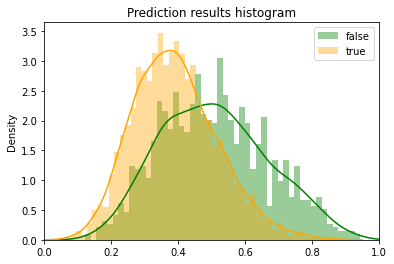

In [16]:
sns.distplot(pred_df.query("truth == 0")["class0"].values, color='green', label='false', bins=50)
sns.distplot(pred_df.query("truth == 1")["class0"].values, color='orange', label='true', bins=50)
# sns.distplot(pred_df['class0'].values, color='orange', label='true', bins=50)
plt.title("Prediction results histogram")
plt.xlim([0., 1.])
plt.legend()

In [19]:
pred_df['predict'] = pred_df['class1'] > 0.5

In [21]:
pred_df.groupby('predict').size()

predict
True    4460
dtype: int64

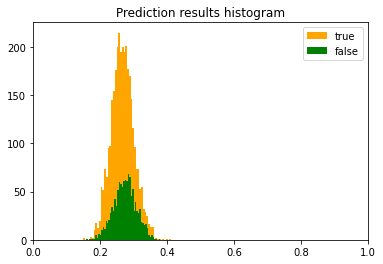

In [25]:
plt.hist(pred_df.query("truth == 1")["class0"].values, color='orange', label='true', bins=50)
plt.hist(pred_df.query("truth == 0")["class0"].values, color='green', label='false', bins=50)
# plt.hist(pred_df['class0'].values, color='orange', label='true', bins=50)
plt.title("Prediction results histogram")
plt.xlim([0., 1.])
plt.legend()